# Simulate a Gaussian random vector with Cholesky decomposition

In this document, we present the simulation of a random vector with arbitrary marginals and Gaussian copula. We assume that this copula has a full rank covariance matrix. We use the Cholesky decomposition to simulate the correlated Gaussian random vector.

## Introduction

The multivariate normal distribution of a k-dimensional random vector $\boldsymbol{X} = (X_1,\ldots,X_k)^T$ can be written in the following notation:

$$
\boldsymbol{X}\ \sim\ \mathcal{N}(\boldsymbol{\mu},\, \Sigma),
$$

where $\boldsymbol{\mu} \in \mathbb{R}^k$ is the mean vector and $\Sigma \in \mathbb{R}^{k\times k}$ is the covariance matrix.

## PDF

Assuming that $\Sigma$ has full rank, the probability density function is:

$$
f_{\boldsymbol{x}}(\boldsymbol{x}) = \frac{1}{\sqrt{(2\pi)^k  |\Sigma|}} \exp\left(-\frac 1 2 (\boldsymbol{x}-\boldsymbol{\mu})^\mathrm{T}{\Sigma}^{-1}(\boldsymbol{x}-\boldsymbol{\mu})\right)
$$

for any $\boldsymbol{x}\in\mathbb{R}^k$. 

## Simulation

Let $L \in\mathbb{R}^{k\times k}$ by the Cholesky factor of $\boldsymbol\Sigma$ :

$$
\boldsymbol\Sigma = L L^T
$$

where $L$ is a lower triangular matrix. 

Let $\boldsymbol{Z} \in \mathbb{R}^k$ be the random vector with independent marginals, such that :

$$
Z_i \sim \mathcal{N}(0, 1)
$$

for $i=1,\ldots, k$. 

Therefore, 

$$
\boldsymbol{X} = \boldsymbol{\mu} + L \boldsymbol{Z} \sim \mathcal{N}(\boldsymbol\mu,\, \boldsymbol\Sigma).
$$

Indeed, its mean is :

$$
\mathbb{E}[\boldsymbol{X}] = \boldsymbol{\mu} + L  \mathbb{E}[\boldsymbol{Z}] = \boldsymbol{\mu}
$$

since $\mathbb{E}[\boldsymbol{Z}] = \boldsymbol{0}$.

Its \textrm{Cov}ariance is:

$$
\textrm{Cov}[\boldsymbol{X}] = \textrm{Cov}[L \boldsymbol{Z}] = L \textrm{Cov}[\boldsymbol{Z}] L^T = L L^T = \boldsymbol\Sigma,
$$

by the properties of the \textrm{Cov}ariance and the definition of $L$.

## Arbitrary marginals with Gaussian copula

Let $\mathbf{X}\in\mathbb{R}^k$ be a random vector with marginal cumulative density function $F_i$ for $i=1,\ldots, k$ and Gaussian copula with correlation matrix $R$. 

Let $\mathbf{Z}\in\mathbb{R}^k$ be a Gaussian random vector Gaussian copula with zero mean and correlation matrix $R$. The previous section shows how to simulate such a vector. 

Let $\mathbf{X}\in\mathbb{R}^k$ be the random vector defined by:

$$
X_i = F_i^{-1}\left(\Phi(Z_i)\right)
$$

for $i=1, \ldots, k$ where $\Phi$ is the standard normal cumulative density function (CDF) and $F_i^{-1}$ is the quantile function of the i-th marginal. 
Therefore, the random vector $\mathbf{X}$ has the required distribution. 

In [1]:
import openturns as ot
import openturns.viewer as otv

In [2]:
ot.__version__

'1.16'

In [3]:
def view_sample(sample, title, figure_size=5.0):
    graph = ot.VisualTest.DrawPairs(sample)
    graph.setTitle(title)
    figure = otv.View(graph).getFigure()
    figure.set_figheight(figure_size)
    figure.set_figwidth(figure_size)
    return graph

In [4]:
ot.RandomGenerator.SetSeed(77)

In [5]:
# Liste des marginales
marginal_collection = [ot.Normal(3.0, 2.0), ot.Uniform(-3.0, -1.0), ot.Beta()]

In [6]:
# Dépendance
R = ot.CorrelationMatrix(3, [1.0, 0.5, 0.3, 0.5, 1.0, 0.9, 0.3, 0.9, 1.0])
print(R)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginal_collection, copula)

[[ 1   0.5 0.3 ]
 [ 0.5 1   0.9 ]
 [ 0.3 0.9 1   ]]


In [7]:
# Simulation
sample_size = 100
sample = distribution.getSample(sample_size)
sample[:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=3 description=[X0,X1,X2] data=[[5.4931,-1.45121,0.0571624],[2.02814,-1.82292,-0.143716],[1.89767,-2.19469,0.11227],[3.54756,-1.82015,0.19982],[1.03405,-2.33888,0.278309]]

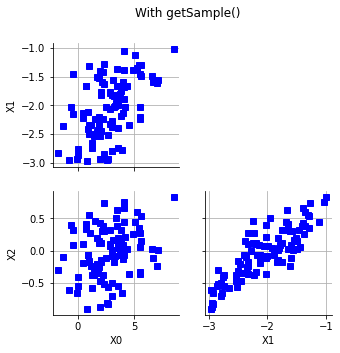

In [8]:
graph = view_sample(sample, "With getSample()")

In [9]:
# Create a gaussian random vector
dimension = R.getDimension()
mu = ot.Point(dimension)
sigma = ot.Point(dimension, 1.0)
distribution = ot.Normal(mu, sigma, R)
sample_z = distribution.getSample(sample_size)
sample_z[:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=3 description=[X0,X1,X2] data=[[0.983271,0.970473,0.985844],[0.70507,-0.48126,-1.25494],[-2.20798,-1.65626,-0.630921],[-0.484814,-1.552,-1.50783],[2.07205,0.517512,0.290387]]

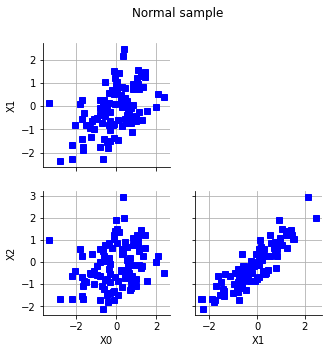

In [10]:
graph = view_sample(sample_z, "Normal sample")

In [11]:
# Simulation pas à pas


def get_realization(marginal_collection, R):
    """
    Generate a new realization with Gaussian copula.
     
    Uses the Cholesky decomposition of R.
    This implementation only if the covariance matrix 
    is full rank. 
    The point is generated by computing the quantile of the 
    CDF of the Gaussian correlated random vector.
    
    Parameters
    ----------
    marginal_collection : list
        The list of univariate marginals.
    R : ot.CorrelationMatrix
        The correlation matrix

    Returns
    -------
    x_correlated : ot.Point()
        The point with given correlation and marginals. 
    """
    dimension = R.getDimension()
    # Generate a realization without correlation
    Z_distribution = ot.Normal(dimension)
    z_decorrelated = Z_distribution.getRealization()
    # Compute correlated Normal realization
    L = R.computeCholesky()
    z_correlated = L * z_decorrelated
    # Apply marginals
    x_correlated = ot.Point(dimension)
    for i in range(dimension):
        marginal = marginal_collection[i]
        cdf = ot.Normal().computeCDF(z_correlated[i])
        x_correlated[i] = marginal.computeQuantile(cdf)[0]
    return x_correlated

In [12]:
def get_sample(marginal_collection, R, sample_size):
    """
    Generate a sample with Gaussian copula.
    
    Parameters
    ----------
    marginal_collection : list
        The list of univariate marginals.
    R : ot.CorrelationMatrix
        The correlation matrix
    sample_size : int
        The size of the sample.

    Returns
    -------
    sample : ot.Sample(sample_size, dimension)
        The sample.
    """
    dimension = R.getDimension()
    sample = ot.Sample(sample_size, dimension)
    for i in range(sample_size):
        sample[i] = get_realization(marginal_collection, R)
    return sample

In [13]:
sample = get_sample(marginal_collection, R, sample_size)

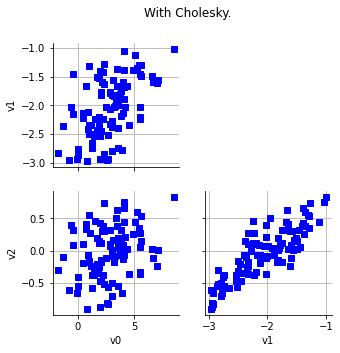

In [15]:
graph = view_sample(sample, "With Cholesky.")